# Reddit Sentiment Analysis - Data Preprocessing & Exploratory Data Analysis

This notebook performs comprehensive preprocessing and exploratory data analysis
on Reddit comments for sentiment analysis.

## Table of Contents
1. Data Loading and Initial Exploration
2. Data Cleaning and Preprocessing
3. Exploratory Data Analysis (EDA)
4. Text Analysis and Visualization

## 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Set plotting style

In [3]:
plt.style.use('default')
sns.set_palette("husl")

## 2. Utility Functions for Visualization and Analysis

In [4]:
def create_count_plot(data, column, title, figsize=(10, 6), palette="viridis"):
    """Create a count plot for categorical data."""
    plt.figure(figsize=figsize)
    ax = sns.countplot(data=data, x=column, palette=palette)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(column.replace('_', ' ').title(), fontsize=12)
    plt.ylabel('Count', fontsize=12)

    # Add value labels on bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                   (p.get_x() + p.get_width()/2., p.get_height()),
                   ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

def create_distribution_plot(data, column, title, figsize=(10, 6), kde=True):
    """Create a distribution plot for numerical data."""
    plt.figure(figsize=figsize)
    sns.histplot(data[column], kde=kde, bins=30)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(column.replace('_', ' ').title(), fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.tight_layout()
    plt.show()

def create_kde_by_category(data, column, category_col, title, figsize=(10, 6)):
    """Create KDE plots grouped by category."""
    plt.figure(figsize=figsize)

    categories = data[category_col].unique()
    category_labels = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
    colors = {-1: 'red', 0: 'gray', 1: 'green'}

    for cat in sorted(categories):
        sns.kdeplot(data[data[category_col] == cat][column],
                   label=category_labels.get(cat, f'Category {cat}'),
                   fill=True, alpha=0.6, color=colors.get(cat))

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(column.replace('_', ' ').title(), fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

def create_boxplot_by_category(data, x_col, y_col, title, figsize=(10, 6)):
    """Create boxplot grouped by category."""
    plt.figure(figsize=figsize)
    sns.boxplot(data=data, x=x_col, y=y_col, palette=['red', 'gray', 'green'])
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(x_col.replace('_', ' ').title(), fontsize=12)
    plt.ylabel(y_col.replace('_', ' ').title(), fontsize=12)
    plt.tight_layout()
    plt.show()

def create_barplot_top_items(items_list, title, n=25, figsize=(12, 8), palette='viridis'):
    """Create horizontal bar plot for top N items."""
    df_items = pd.DataFrame(items_list, columns=['item', 'count'])

    plt.figure(figsize=figsize)
    sns.barplot(data=df_items, x='count', y='item', palette=palette)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Items', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_word_cloud(text_series, title, figsize=(12, 6)):
    """Generate and display word cloud."""
    text = ' '.join(text_series.dropna())
    if text.strip():  # Check if text is not empty
        wordcloud = WordCloud(width=800, height=400,
                            background_color='white',
                            max_words=100,
                            colormap='viridis').generate(text)

        plt.figure(figsize=figsize)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(title, fontsize=14, fontweight='bold')
        plt.axis("off")
        plt.tight_layout()
        plt.show()
    else:
        print(f"No text available for {title}")

def get_top_ngrams(corpus, ngram_range=(2, 2), n=25):
    """Extract top N n-grams from corpus."""
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

def plot_top_words_by_category(df, text_col, category_col, n=20, figsize=(12, 8)):
    """Plot top N words with stacked sentiment categories."""
    word_category_counts = {}

    for idx, row in df.iterrows():
        words = str(row[text_col]).split()
        category = row[category_col]

        for word in words:
            if word not in word_category_counts:
                word_category_counts[word] = {-1: 0, 0: 0, 1: 0}
            word_category_counts[word][category] += 1

    # Get total counts and top words
    total_word_counts = {word: sum(counts.values()) for word, counts in word_category_counts.items()}
    most_common_words = sorted(total_word_counts.items(), key=lambda x: x[1], reverse=True)[:n]
    top_words = [word for word, _ in most_common_words]

    # Prepare data for plotting
    negative_counts = [word_category_counts[word][-1] for word in top_words]
    neutral_counts = [word_category_counts[word][0] for word in top_words]
    positive_counts = [word_category_counts[word][1] for word in top_words]

    # Create stacked bar chart
    plt.figure(figsize=figsize)
    plt.barh(top_words, negative_counts, color='red', label='Negative (-1)', alpha=0.8)
    plt.barh(top_words, neutral_counts, left=negative_counts, color='gray', label='Neutral (0)', alpha=0.8)
    plt.barh(top_words, positive_counts,
             left=[i+j for i,j in zip(negative_counts, neutral_counts)],
             color='green', label='Positive (1)', alpha=0.8)

    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('Words', fontsize=12)
    plt.title(f'Top {n} Most Frequent Words by Sentiment Category', fontsize=14, fontweight='bold')
    plt.legend(title='Sentiment', loc='lower right')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## 3. Data Loading and Initial Exploration

In [ ]:
print("Loading Reddit sentiment dataset...")
import pandas as pd
data = pd.read_csv('https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv')

Loading Reddit sentiment dataset...


In [6]:
print("\n=== Dataset Overview ===")
print(f"Dataset shape: {data.shape}")
print(f"Columns: {list(data.columns)}")


=== Dataset Overview ===
Dataset shape: (37249, 2)
Columns: ['clean_comment', 'category']


In [7]:
# Display first few rows
print("\n=== First 5 rows ===")
print(data.head())


=== First 5 rows ===
                                       clean_comment  category
0   family mormon have never tried explain them t...         1
1  buddhism has very much lot compatible with chr...         1
2  seriously don say thing first all they won get...        -1
3  what you have learned yours and only yours wha...         0
4  for your own benefit you may want read living ...         1


In [8]:
# Display sample comments
print("\n=== Sample comment ===")
sample_comment = data.sample()['clean_comment'].values[0] if not data.empty else "No data"
print(f"Sample comment: {sample_comment}")


=== Sample comment ===
Sample comment: also because bjp has highest number mps and mlas 


In [9]:
# Dataset information
print("\n=== Dataset Info ===")
print(data.info())


=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB
None


## 4. Data Quality Assessment

### Missing Values Analysis

In [10]:
print("\n=== Missing Values Analysis ===")
missing_values = data.isnull().sum()
print(missing_values)

if missing_values.sum() > 0:
    print("\n=== Rows with missing clean_comment ===")
    missing_rows = data[data['clean_comment'].isna()]
    print(f"Number of rows with missing comments: {len(missing_rows)}")

    if len(missing_rows) > 0:
        print("\nCategory distribution of missing comments:")
        print(missing_rows['category'].value_counts())


=== Missing Values Analysis ===
clean_comment    100
category           0
dtype: int64

=== Rows with missing clean_comment ===
Number of rows with missing comments: 100

Category distribution of missing comments:
category
0    100
Name: count, dtype: int64


In [11]:
data[data['clean_comment'].isna()].groupby('clean_comment' , dropna=False)['category'].value_counts()

,,count
clean_comment,category,
NaN,0,100


In [12]:
# Remove rows with missing comments
print("\nRemoving rows with missing comments...")
initial_shape = data.shape
data.dropna(inplace=True)
print(f"Shape after removing missing values: {data.shape}")
print(f"Removed {initial_shape[0] - data.shape[0]} rows")


Removing rows with missing comments...
Shape after removing missing values: (37149, 2)
Removed 100 rows


### Duplicate Analysis

In [13]:
# Check for duplicates
print("\n=== Duplicate Analysis ===")
duplicate_count = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    print("Removing duplicate rows...")
    data.drop_duplicates(inplace=True)
    print(f"Shape after removing duplicates: {data.shape}")


=== Duplicate Analysis ===
Number of duplicate rows: 350
Removing duplicate rows...
Shape after removing duplicates: (36799, 2)


### Empty Comments Analysis

In [14]:
print("\n=== Empty Comments Analysis ===")
empty_comments = data[(data['clean_comment'].str.strip() == '')]
print(f"Number of empty comments: {len(empty_comments)}")

if len(empty_comments) > 0:
    print("Removing empty comments...")
    data = data[~(data['clean_comment'].str.strip() == '')]
    print(f"Shape after removing empty comments: {data.shape}")


=== Empty Comments Analysis ===
Number of empty comments: 6
Removing empty comments...
Shape after removing empty comments: (36793, 2)


## 5. Basic Text Preprocessing

In [15]:
# Convert to lowercase
print("Converting text to lowercase...")
data['clean_comment'] = data['clean_comment'].str.lower()

Converting text to lowercase...


### leading/trailing whitespaces

In [16]:
# Check for leading/trailing whitespaces
whitespace_issues = data[data['clean_comment'].apply(lambda x: x.endswith(' ') or x.startswith(' '))]
print(f"Comments with leading/trailing whitespaces: {len(whitespace_issues)}")
whitespace_issues.head()

Comments with leading/trailing whitespaces: 32266


,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [17]:
# Remove leading and trailing whitespaces
data['clean_comment'] = data['clean_comment'].str.strip()
print("Removed leading and trailing whitespaces")

Removed leading and trailing whitespaces


### Check for URLs

In [18]:
url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
comments_with_urls = data[data['clean_comment'].str.contains(url_pattern, regex=True)]
print(f"Comments containing URLs: {len(comments_with_urls)}")

Comments containing URLs: 0


### Newline Characters

In [19]:
# Check for newline characters
comments_with_newline = data[data['clean_comment'].str.contains('\n')]
print(f"Comments with newline characters: {len(comments_with_newline)}")
comments_with_newline.head()

Comments with newline characters: 204


,clean_comment,category
448,what missing jpg\nand why this brilliant edit ...,1
781,india has been ruined congress and populist sc...,-1
847,like aap for its stand corruption and making p...,-1
871,reduced trade\ndeficit stronger rupee aren the...,0
1354,amsa press conference australian maritime safe...,1


In [20]:
# Remove newline characters
data['clean_comment'] = data['clean_comment'].str.replace('\n', ' ', regex=True)
print("Removed newline characters")

Removed newline characters


## 6. Exploratory Data Analysis (EDA)

### 6.1 Sentiment Distribution Analysis

In [21]:
print("\n=== Sentiment Distribution ===")
sentiment_counts = data['category'].value_counts().sort_index()
sentiment_percentages = data['category'].value_counts(normalize=True).mul(100).round(2).sort_index()

print("Sentiment counts:")
for category, count in sentiment_counts.items():
    label = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}.get(category, f'Category {category}')
    percentage = sentiment_percentages[category]
    print(f"  {label}: {count} ({percentage}%)")


=== Sentiment Distribution ===
Sentiment counts:
  Negative: 8250 (22.42%)
  Neutral: 12772 (34.71%)
  Positive: 15771 (42.86%)


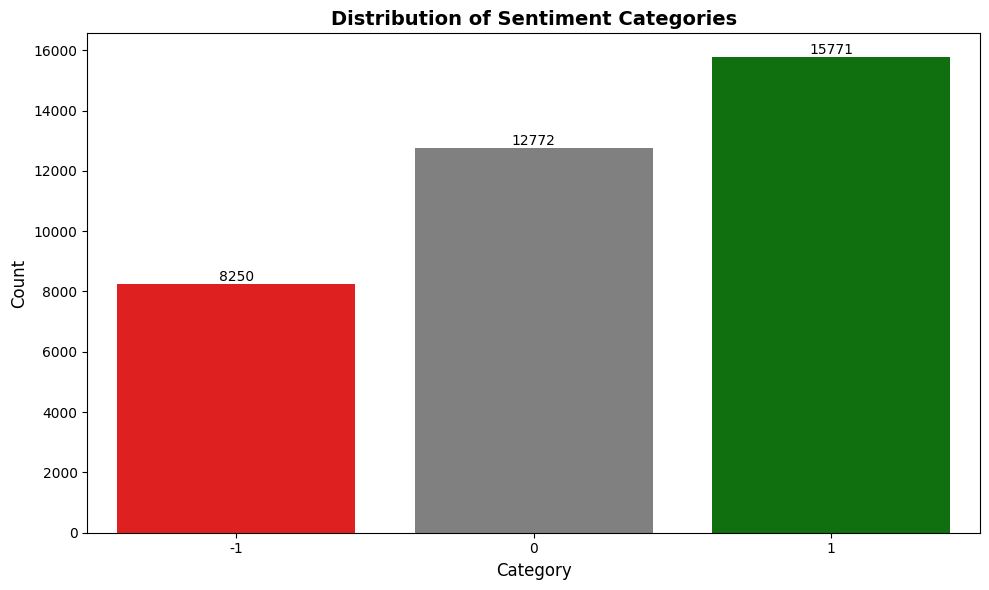

In [22]:
# Plot sentiment distribution
create_count_plot(data, 'category', 'Distribution of Sentiment Categories', palette=['red', 'gray', 'green'])

### 6.2 Word Count Analysis

In [23]:
data['word_count'] = data['clean_comment'].apply(lambda x: len(str(x).split()))

word_count_stats = data['word_count'].describe()
print("Word count statistics:")
print(word_count_stats)

Word count statistics:
count    36793.000000
mean        29.667464
std         56.790738
min          1.000000
25%          6.000000
50%         13.000000
75%         30.000000
max       1307.000000
Name: word_count, dtype: float64


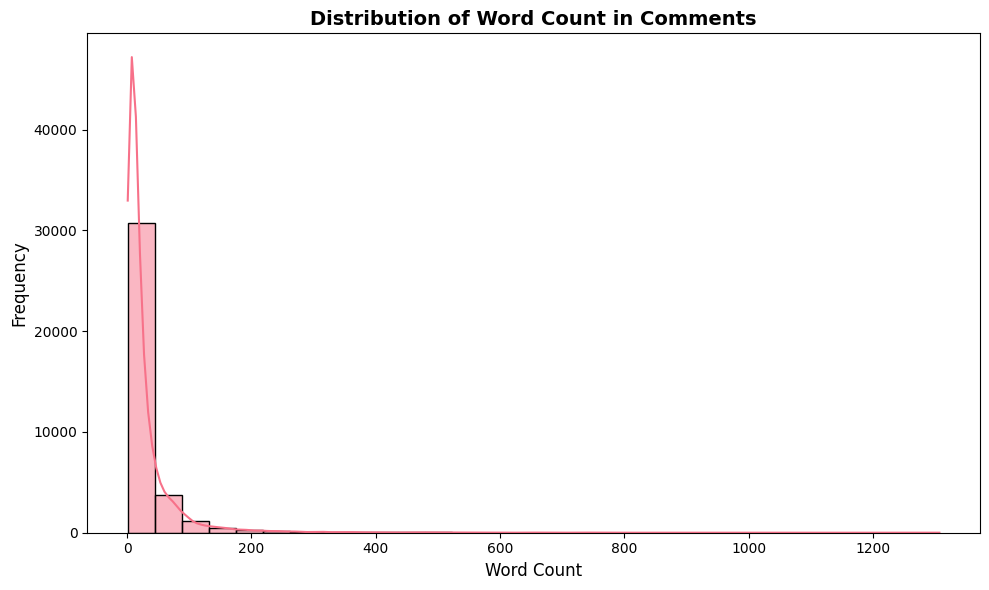

In [24]:
# Plot word count distribution
create_distribution_plot(data, 'word_count', 'Distribution of Word Count in Comments')

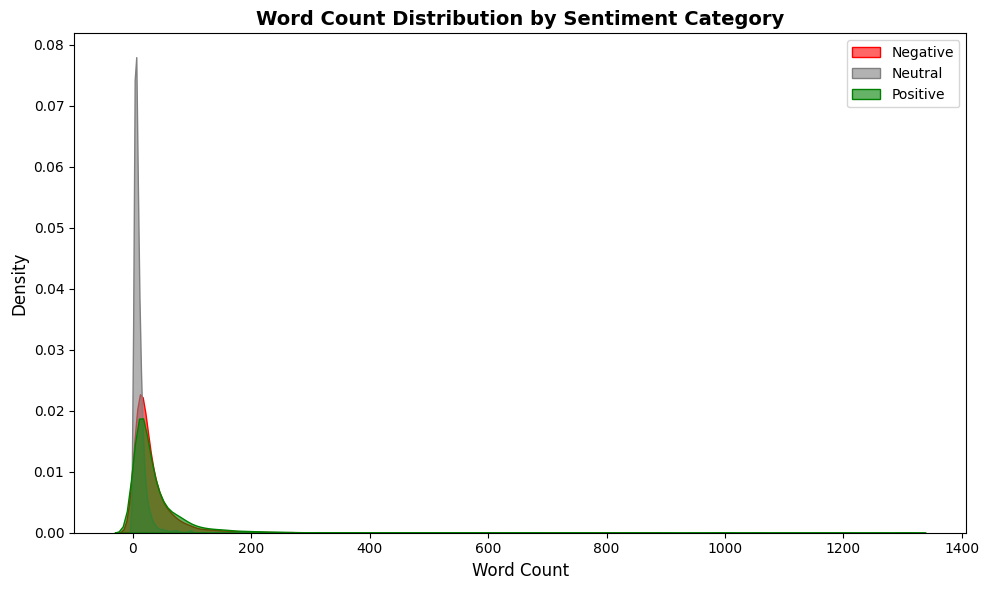

In [25]:
# Word count distribution by sentiment
create_kde_by_category(data, 'word_count', 'category', 'Word Count Distribution by Sentiment Category')

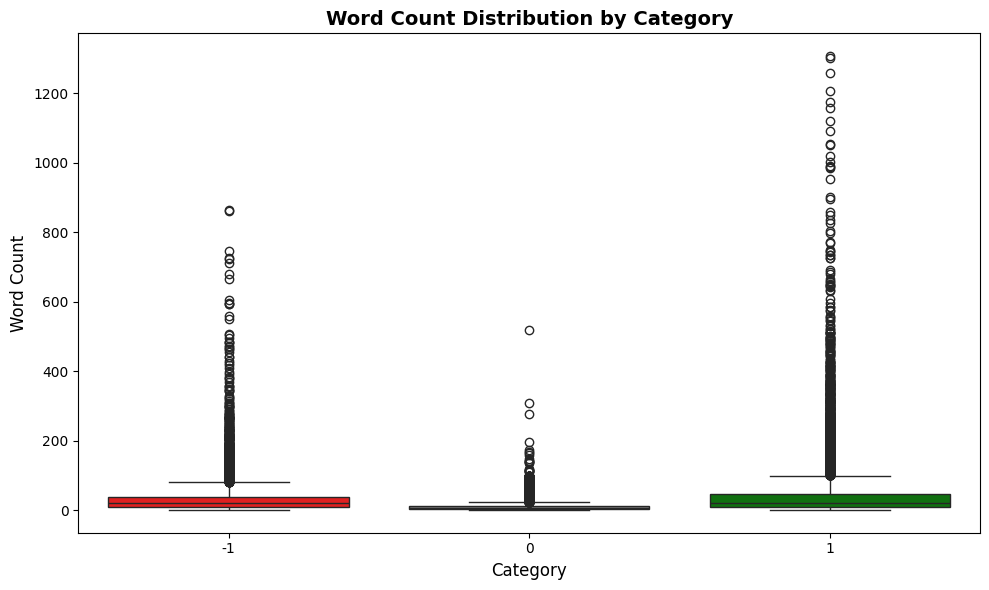

In [26]:
# Boxplot of word count by category
create_boxplot_by_category(data, 'category', 'word_count', 'Word Count Distribution by Category')

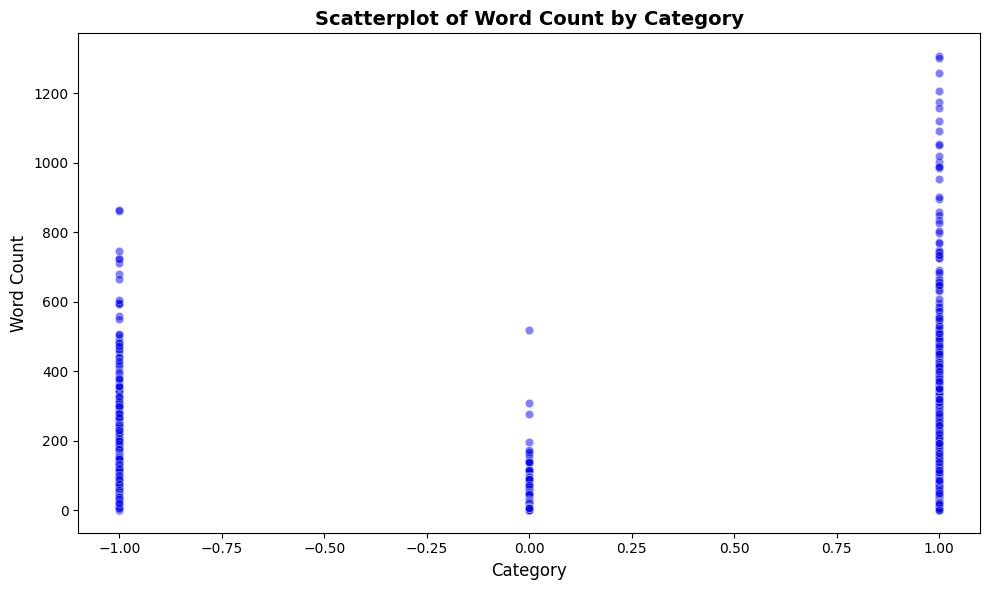

In [27]:
# Scatterplot of word count vs category
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='category', y='word_count', alpha=0.5, color='blue')
plt.title('Scatterplot of Word Count by Category', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.tight_layout()
plt.show()

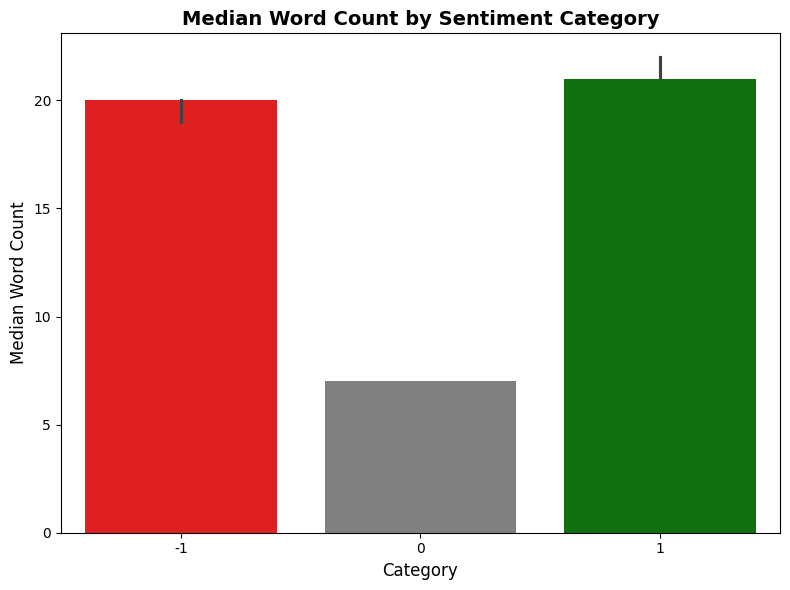

In [28]:
# Median word count by sentiment
plt.figure(figsize=(8, 6))
sns.barplot(data=data, x='category', y='word_count', estimator='median', palette=['red', 'gray', 'green'])
plt.title('Median Word Count by Sentiment Category', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Median Word Count', fontsize=12)
plt.tight_layout()
plt.show()

### Word Count Insights by Sentiment Category

Based on the analysis of word counts across different sentiment categories:

*   **Positive comments (Category 1)**: These comments tend to be more verbose, with a relatively high median word count and a notable presence of longer comments (outliers).
*   **Neutral comments (Category 0)**: These comments are generally shorter, exhibiting the lowest median word count and a tighter distribution (smaller interquartile range).
*   **Negative comments (Category -1)**: The word count distribution for negative comments is somewhat similar to positive comments, though with a slightly lower median and fewer extreme outliers.

Overall, the average word count appears to be higher for positive and neutral comments compared to negative comments. This suggests that expressing positive or neutral sentiment might require more detailed explanations or context than expressing negative sentiment in this dataset.

### 6.3 Stop Words Analysis

In [29]:
# Download NLTK data
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [30]:
# Define stop words
stop_words = set(stopwords.words('english'))

In [31]:
# Count stop words in each comment
data['num_stop_words'] = data['clean_comment'].apply(
    lambda x: len([word for word in str(x).split() if word in stop_words])
)

stop_word_stats = data['num_stop_words'].describe()
print("Stop words count statistics:")
print(stop_word_stats)

Stop words count statistics:
count    36793.000000
mean         9.840078
std         19.381327
min          0.000000
25%          1.000000
50%          4.000000
75%         10.000000
max        463.000000
Name: num_stop_words, dtype: float64


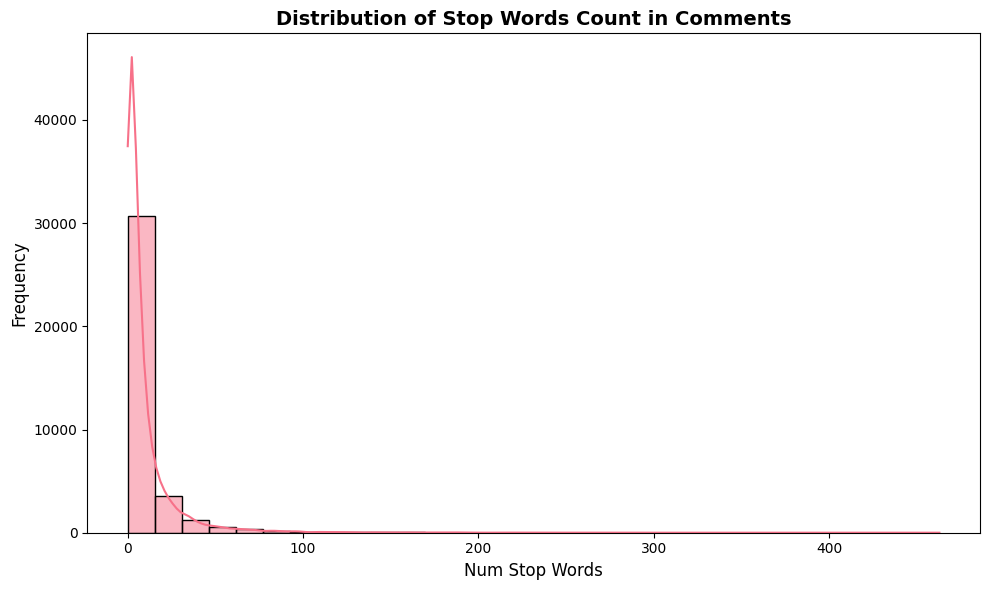

In [32]:
# Plot stop words distribution
create_distribution_plot(data, 'num_stop_words', 'Distribution of Stop Words Count in Comments')

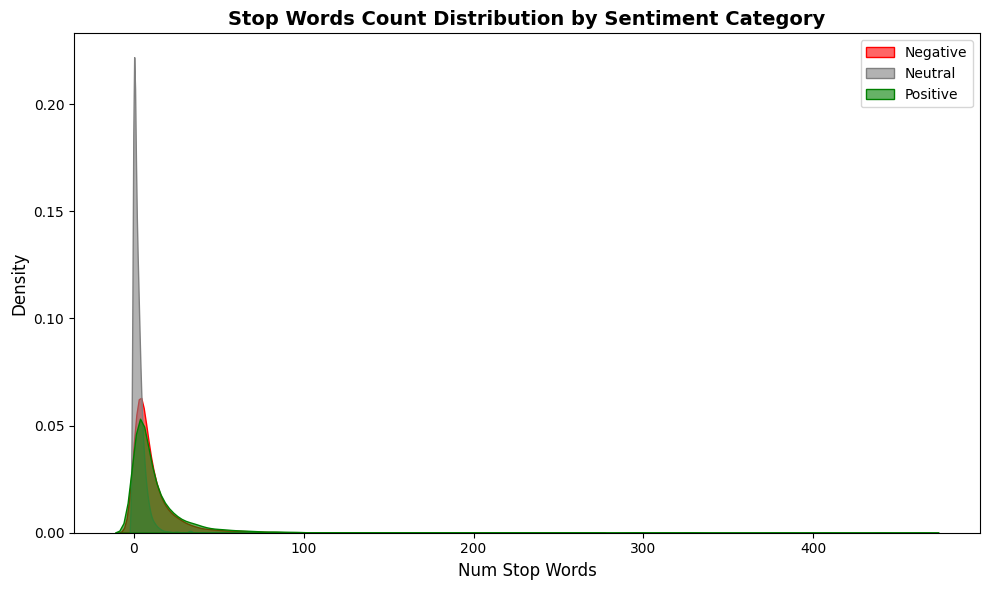

In [33]:
# Stop words distribution by sentiment
create_kde_by_category(data, 'num_stop_words', 'category', 'Stop Words Count Distribution by Sentiment Category')

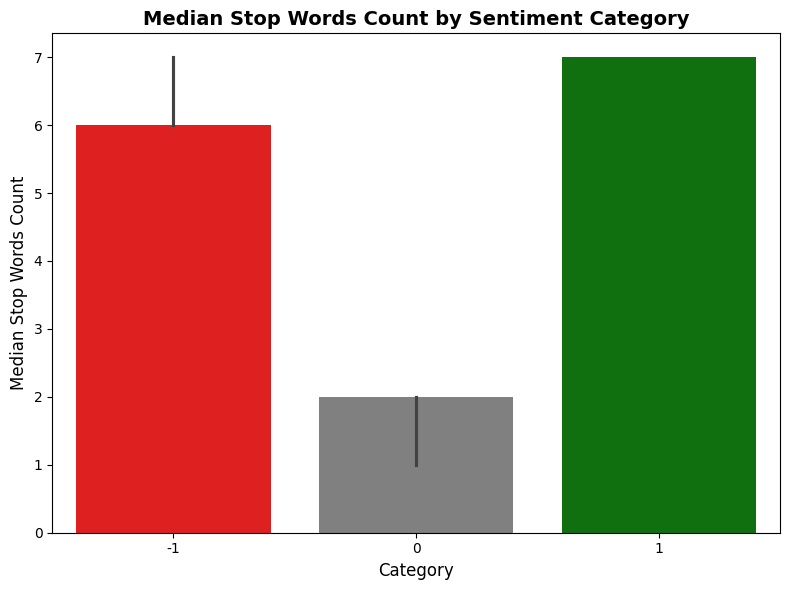

In [34]:
# Median stop words count by sentiment
plt.figure(figsize=(8, 6))
sns.barplot(data=data, x='category', y='num_stop_words', estimator='median', palette=['red', 'gray', 'green'])
plt.title('Median Stop Words Count by Sentiment Category', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Median Stop Words Count', fontsize=12)
plt.tight_layout()
plt.show()


=== Most Common Stop Words ===


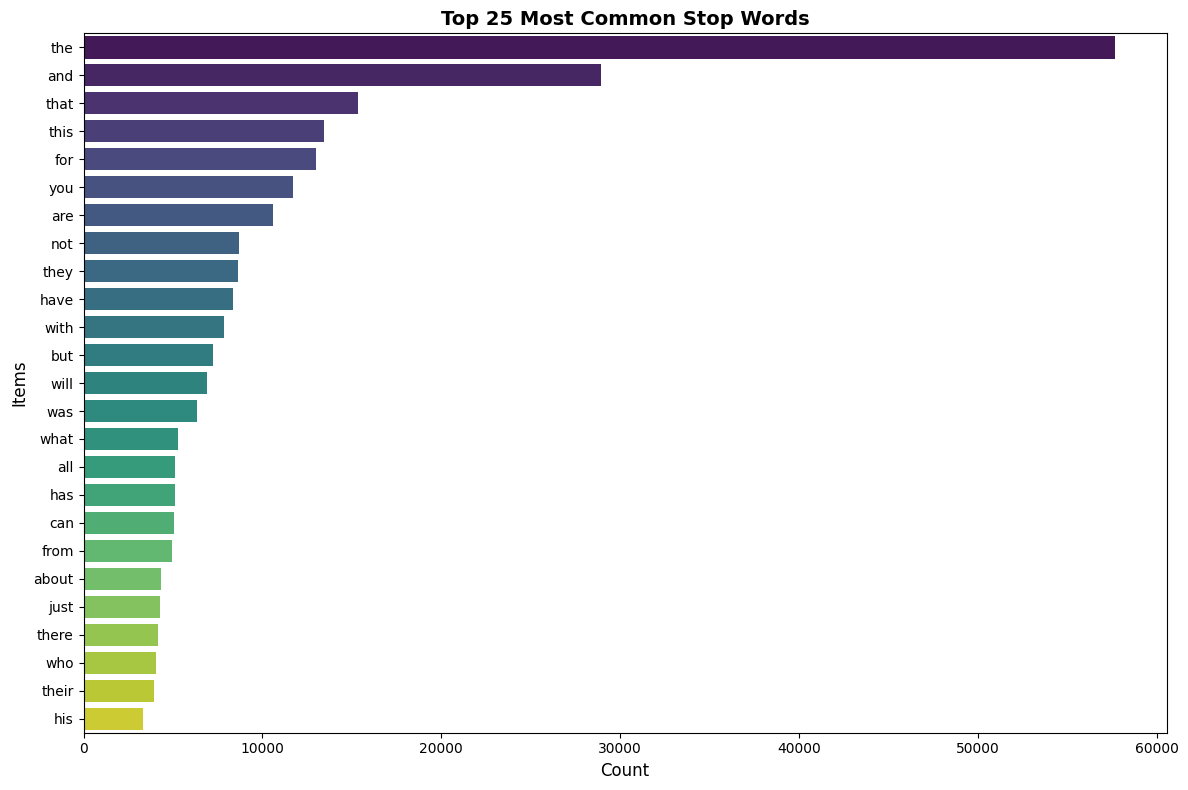

In [35]:
# Most common stop words
print("\n=== Most Common Stop Words ===")
all_stop_words = [word for comment in data['clean_comment']
                 for word in str(comment).split() if word in stop_words]
most_common_stop_words = Counter(all_stop_words).most_common(25)

create_barplot_top_items(most_common_stop_words, 'Top 25 Most Common Stop Words', palette='viridis')

### 6.4 Character Analysis

In [36]:
# Count characters
data['num_chars'] = data['clean_comment'].apply(lambda x: len(str(x)))

char_stats = data['num_chars'].describe()
print("Character count statistics:")
print(char_stats)

Character count statistics:
count    36793.000000
mean       181.852798
std        359.702163
min          1.000000
25%         38.000000
50%         80.000000
75%        184.000000
max       8664.000000
Name: num_chars, dtype: float64


In [37]:
# Character frequency analysis
all_text = ' '.join(data['clean_comment'].astype(str))
char_frequency = Counter(all_text)
char_frequency_df = pd.DataFrame(char_frequency.items(),
                                columns=['character', 'frequency']).sort_values(by='frequency', ascending=False)

print(f"\nMost common characters: {char_frequency_df.head(10)['character'].values}")
print(f"Least common characters: {char_frequency_df.tail(10)['character'].values}")


Most common characters: [' ' 'e' 't' 'a' 'i' 'n' 'o' 's' 'r' 'h']
Least common characters: ['遥' '则' '豹' '皿' '煮' '唯' '统' '段' '她' '谁']


In [38]:
# Punctuation analysis
data['num_punctuation_chars'] = data['clean_comment'].apply(
    lambda x: sum([1 for char in str(x) if char in '.,!?;:"\'()[]{}-'])
)

punct_stats = data['num_punctuation_chars'].describe()
print("\nPunctuation count statistics:")
print(punct_stats)


Punctuation count statistics:
count    36793.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: num_punctuation_chars, dtype: float64


### 6.5 N-gram Analysis

Analyzing top bigrams...


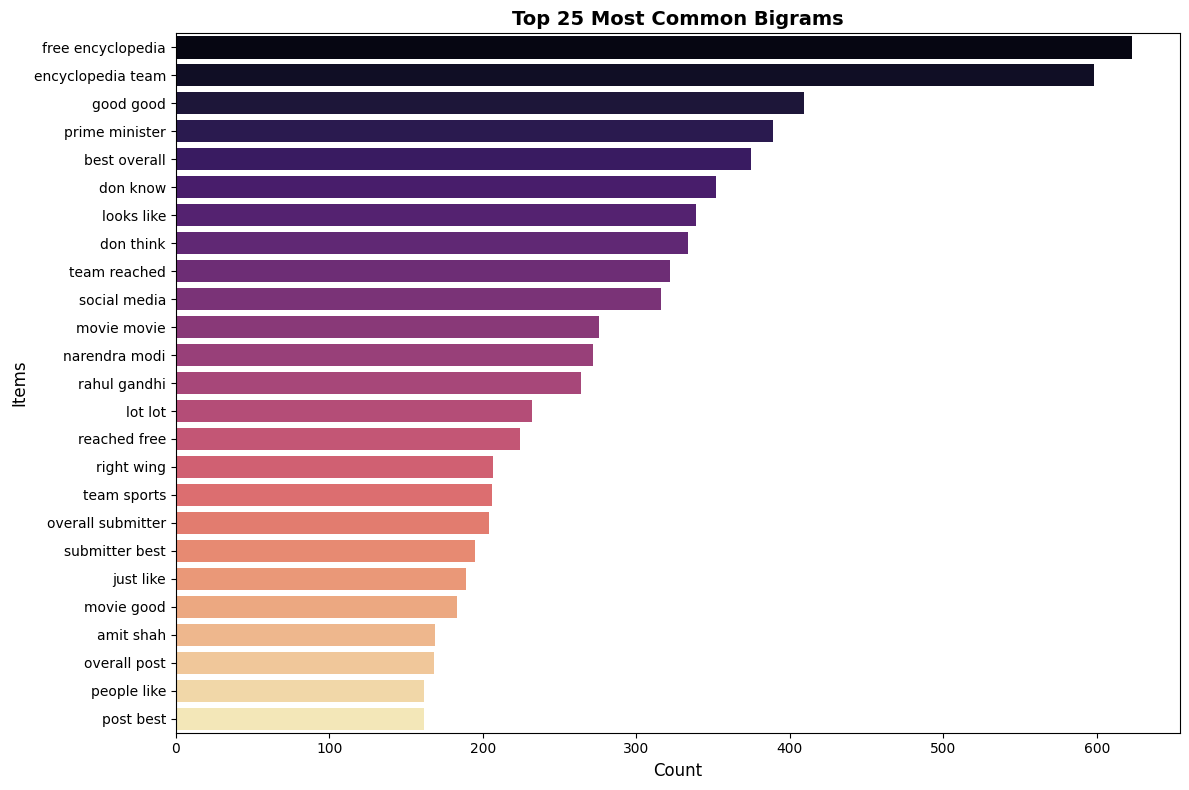

In [39]:
# Top bigrams
print("Analyzing top bigrams...")
top_25_bigrams = get_top_ngrams(data['clean_comment'].astype(str), ngram_range=(2, 2), n=25)
create_barplot_top_items(top_25_bigrams, 'Top 25 Most Common Bigrams', palette='magma')

Analyzing top trigrams...


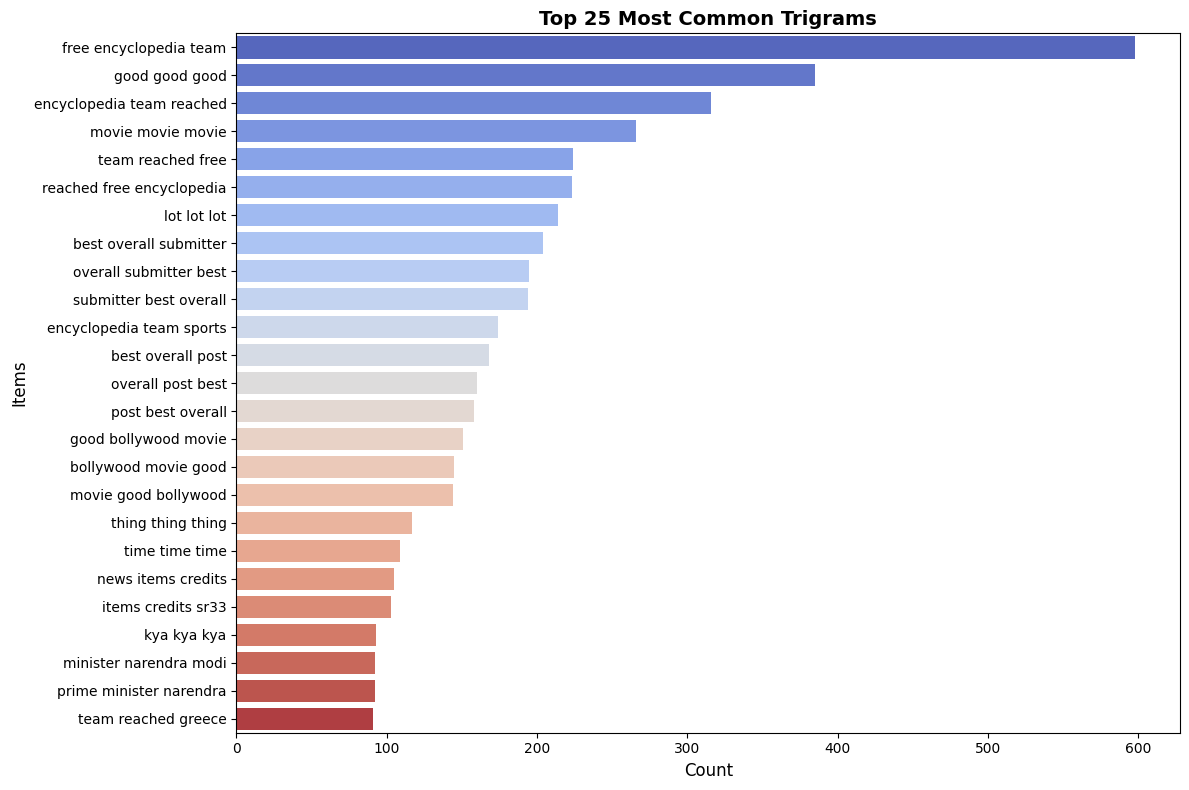

In [40]:
# Top trigrams
print("Analyzing top trigrams...")
top_25_trigrams = get_top_ngrams(data['clean_comment'].astype(str), ngram_range=(3, 3), n=25)
create_barplot_top_items(top_25_trigrams, 'Top 25 Most Common Trigrams', palette='coolwarm')

## 7. Advanced Text Preprocessing

In [41]:
# Remove non-English characters
print("\nRemoving non-English characters...")
data['clean_comment'] = data['clean_comment'].apply(
    lambda x: re.sub(r'[^A-Za-z0-9\s!?.,]', '', str(x))
)


Removing non-English characters...


In [42]:
# Updated character frequency after cleaning
all_text_clean = ' '.join(data['clean_comment'].astype(str))
char_frequency_clean = Counter(all_text_clean)
char_frequency_clean_df = pd.DataFrame(char_frequency_clean.items(),
                                      columns=['character', 'frequency']).sort_values(by='frequency', ascending=False)

print("Character frequency after cleaning:")
print(char_frequency_clean_df.head(20))

Character frequency after cleaning:
   character  frequency
6               1091592
12         e     666610
13         t     491287
1          a     481134
3          i     401388
9          n     388465
7          o     379908
17         s     355279
8          r     331425
10         h     296748
4          l     250104
14         d     221980
18         u     170377
22         c     167821
2          m     155561
16         p     135139
21         g     132927
5          y     115420
25         w     110522
24         b      88199


In [43]:
# Remove stop words (keeping important ones for sentiment)
print("\nRemoving stop words (keeping sentiment-important ones)...")
stop_words_filtered = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}

data['clean_comment'] = data['clean_comment'].apply(
    lambda x: ' '.join([word for word in str(x).split() if word.lower() not in stop_words_filtered])
)


Removing stop words (keeping sentiment-important ones)...


In [44]:
# Lemmatization
print("Applying lemmatization...")
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

Applying lemmatization...


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [45]:
lemmatizer = WordNetLemmatizer()
data['clean_comment'] = data['clean_comment'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word) for word in str(x).split()])
)

In [46]:
print("Advanced preprocessing completed!")
print(f"Final dataset shape: {data.shape}")
print("\nSample of processed comments:")
print(data[['clean_comment', 'category']].head())

Advanced preprocessing completed!
Final dataset shape: (36793, 6)

Sample of processed comments:
                                       clean_comment  category
0  family mormon never tried explain still stare ...         1
1  buddhism much lot compatible christianity espe...         1
2  seriously say thing first get complex explain ...        -1
3  learned want teach different focus goal not wr...         0
4  benefit may want read living buddha living chr...         1


## 8. Text Visualization


Generating word clouds...


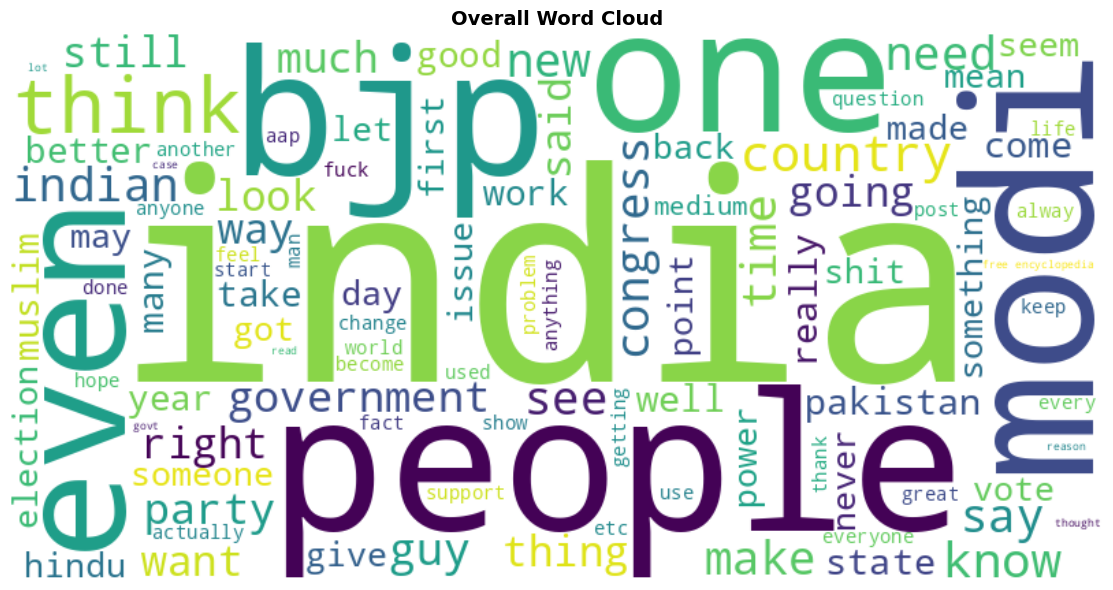

In [47]:
# Overall word cloud
print("\nGenerating word clouds...")
plot_word_cloud(data['clean_comment'], 'Overall Word Cloud')

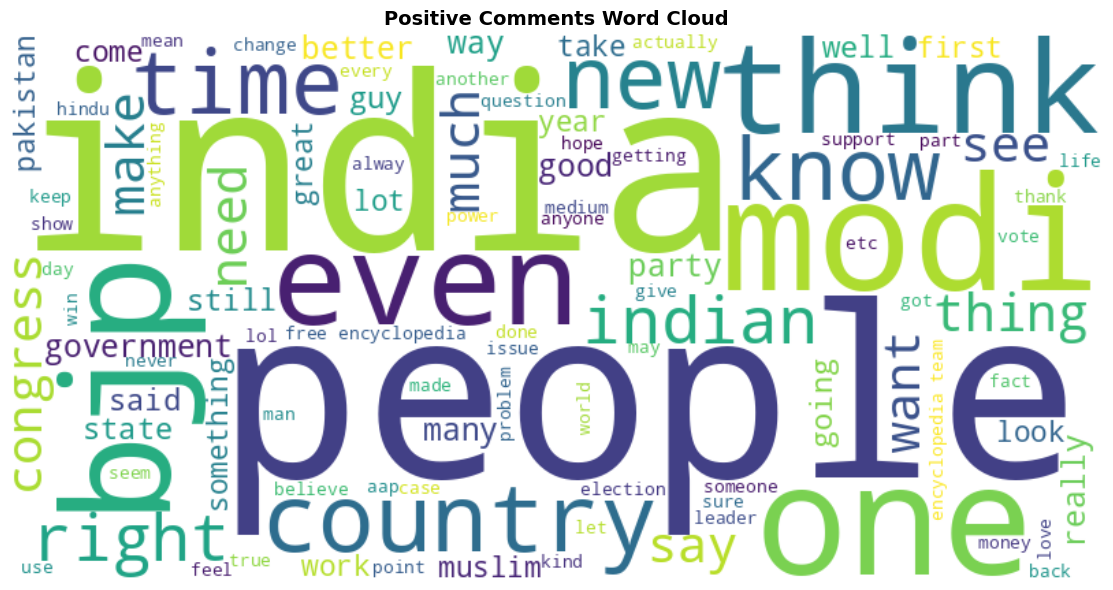

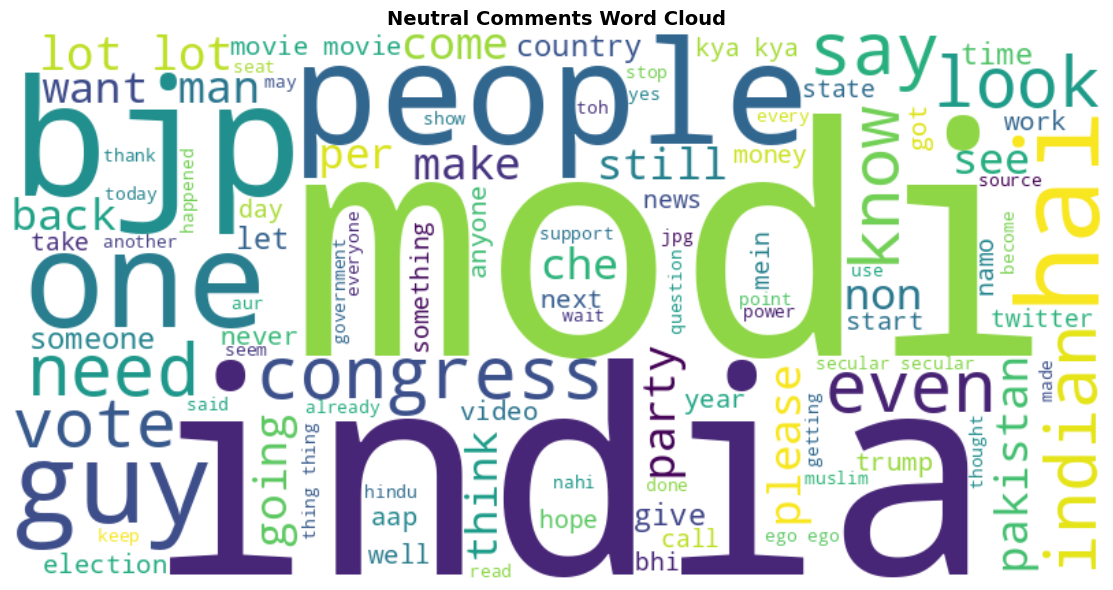

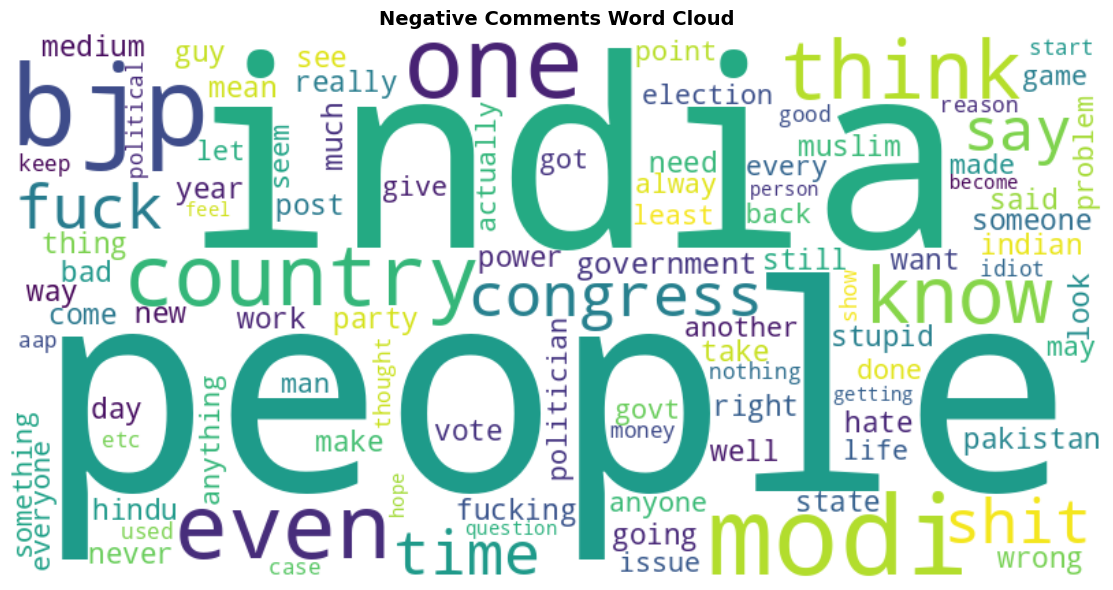

In [48]:
# Word clouds by sentiment
plot_word_cloud(data[data['category'] == 1]['clean_comment'], 'Positive Comments Word Cloud')
plot_word_cloud(data[data['category'] == 0]['clean_comment'], 'Neutral Comments Word Cloud')
plot_word_cloud(data[data['category'] == -1]['clean_comment'], 'Negative Comments Word Cloud')


Analyzing most frequent words...


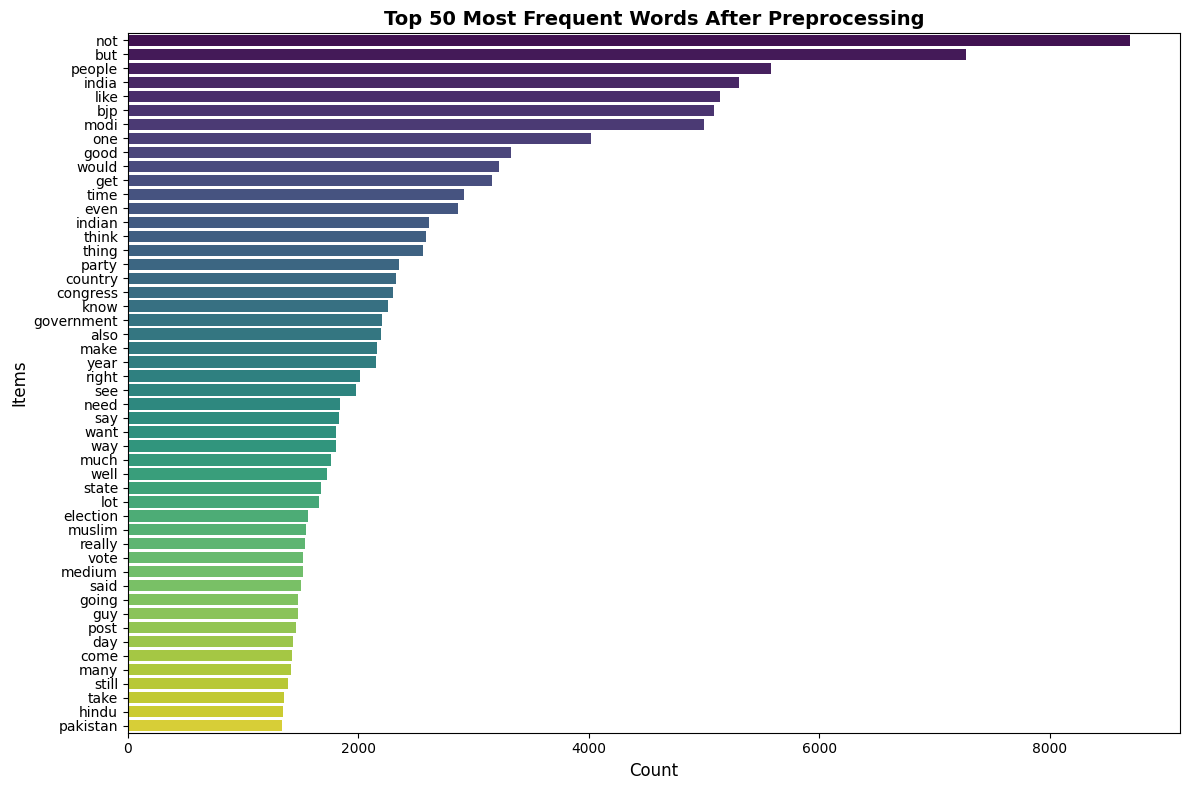

In [49]:
# Top words overall
print("\nAnalyzing most frequent words...")
all_words = ' '.join(data['clean_comment'].astype(str)).split()
word_counter = Counter(all_words)
most_common_words = word_counter.most_common(50)

create_barplot_top_items(most_common_words, 'Top 50 Most Frequent Words After Preprocessing')


Analyzing words by sentiment category...


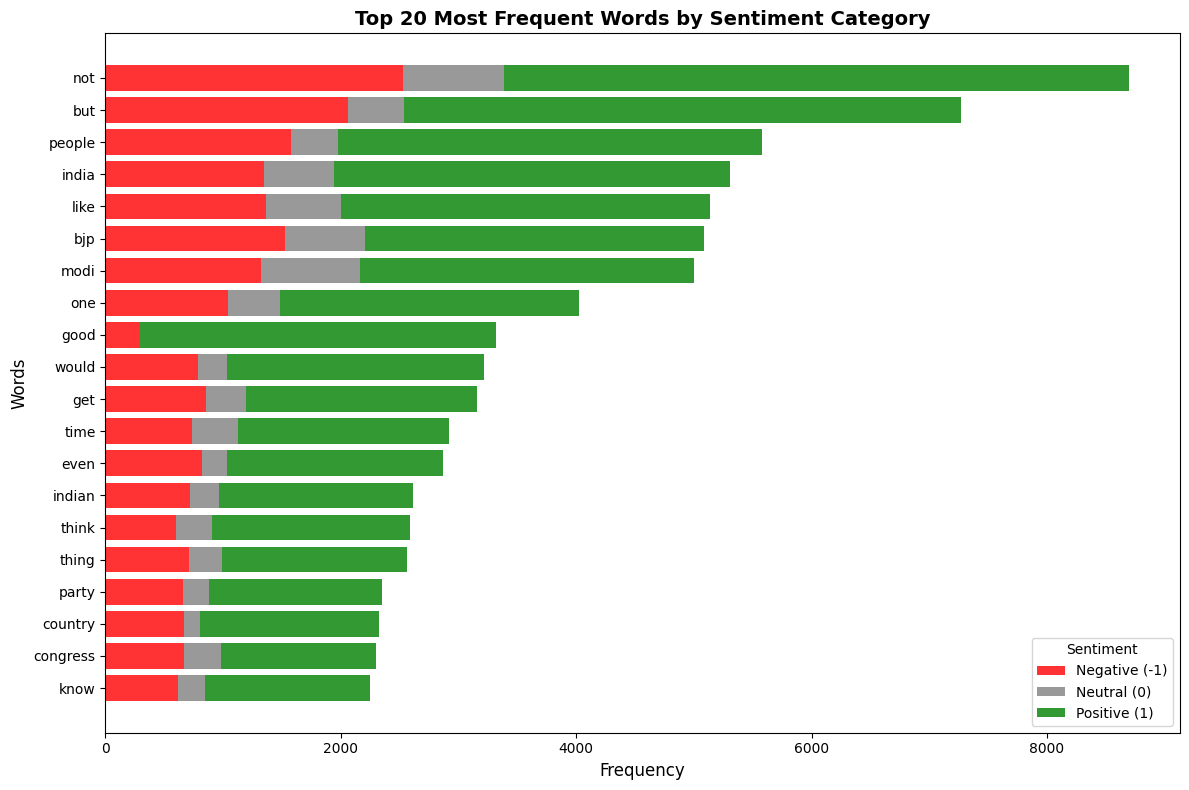

In [50]:
# Top words by category with stacked visualization
print("\nAnalyzing words by sentiment category...")
plot_top_words_by_category(data, 'clean_comment', 'category', n=20)

## 9. Final Dataset Summary

In [51]:
print("\n" + "="*50)
print("FINAL DATASET SUMMARY")
print("="*50)

print(f"Final dataset shape: {data.shape}")
print(f"Total comments: {len(data)}")

final_sentiment_dist = data['category'].value_counts().sort_index()
print("\nFinal sentiment distribution:")
for category, count in final_sentiment_dist.items():
    label = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}.get(category, f'Category {category}')
    percentage = (count / len(data) * 100)
    print(f"  {label}: {count} ({percentage:.2f}%)")

print(f"\nAverage word count per comment: {data['word_count'].mean():.2f}")
print(f"Average character count per comment: {data['num_chars'].mean():.2f}")


FINAL DATASET SUMMARY
Final dataset shape: (36793, 6)
Total comments: 36793

Final sentiment distribution:
  Negative: 8250 (22.42%)
  Neutral: 12772 (34.71%)
  Positive: 15771 (42.86%)

Average word count per comment: 29.67
Average character count per comment: 181.85
